In [73]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import platform
import os
import gc

# Mac M4 Max optimization (safe for all platforms)
if platform.system() == 'Darwin' and platform.machine() == 'arm64':
    os.environ['ACCELERATE'] = '1'
    print("🚀 Mac M4 Max GPU acceleration enabled")

print(f"System: {platform.system()} {platform.machine()}")
print(f"NumPy version: {np.__version__}")
print("📊 Testing C₆ and 2×4 Grid with fixed percentage scale")
print("🎯 Focus: Meaningful Monte Carlo convergence behavior")
print("✅ Cell 1: Setup complete!")

🚀 Mac M4 Max GPU acceleration enabled
System: Darwin arm64
NumPy version: 1.24.4
📊 Testing C₆ and 2×4 Grid with fixed percentage scale
🎯 Focus: Meaningful Monte Carlo convergence behavior
✅ Cell 1: Setup complete!


In [59]:
# Cell 2: Helper Functions

def create_c6_graph():
    """
    Create a 6-Cycle (C₆) graph - larger cycle for meaningful Monte Carlo behavior.
    
    Returns:
        List of edges as (u, v) tuples for C₆
    """
    edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]
    
    print(f"Created C₆ (6-Cycle) graph:")
    print(f"  Vertices: 6")
    print(f"  Edges: {len(edges)}")
    print(f"  Total mappings (6^6): {6**6:,}")
    print(f"  Type: Cycle graph (good for Monte Carlo convergence study)")
    return edges

def create_grid_2x4():
    """
    Create a 2×4 Grid graph - larger graph for meaningful variance study.
    
    Returns:
        List of edges as (u, v) tuples for 2×4 grid
    """
    edges = [(0, 1), (1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (0, 4), (1, 5), (2, 6), (3, 7)]
    
    print(f"Created 2×4 Grid graph:")
    print(f"  Vertices: 8")
    print(f"  Edges: {len(edges)}")
    print(f"  Total mappings (6^8): {6**8:,}")
    print(f"  Type: Grid graph (excellent for convergence analysis)")
    return edges

def generate_test_matrix(size, seed=42):
    """Generate a symmetric weight matrix with all POSITIVE numbers."""
    np.random.seed(seed)
    # Generate positive numbers using uniform distribution [0,1] then scale to [0,6]
    W = np.random.rand(size, size) * 6  # All positive numbers 0 to 6
    W = (W + W.T) / 2  # Make symmetric
    
    print(f"Generated {size}×{size} positive weight matrix:")
    print(f"  Range: [{np.min(W):.3f}, {np.max(W):.3f}]")
    print(f"  All positive: {np.all(W >= 0)}")
    print(f"  Symmetric: {np.allclose(W, W.T)}")
    return W

print("✅ Cell 2: Larger graph functions loaded (C₆ and 2×4 Grid)!")

✅ Cell 2: Larger graph functions loaded (C₆ and 2×4 Grid)!


In [60]:
# Cell 3: Exact Density Computation

def compute_exact_density(H_edges, W, graph_name="Unknown", batch_size=2_000_000):
    """
    Compute exact homomorphism density using brute-force enumeration.
    
    Args:
        H_edges: Edge list of graph H
        W: Weight matrix (target graph G)
        graph_name: Name of the graph for display
        batch_size: Assignments per batch (memory vs speed tradeoff)
    
    Returns:
        Exact homomorphism density
    """
    # Determine number of vertices from edge list
    vertices_in_edges = set()
    for u, v in H_edges:
        vertices_in_edges.add(u)
        vertices_in_edges.add(v)
    n_vertices = len(vertices_in_edges)
    
    n_labels = W.shape[0]
    total_mappings = n_labels ** n_vertices
    
    print(f"\n🔧 Computing EXACT density for {graph_name}:")
    print(f"  Graph vertices: {n_vertices}")
    print(f"  Graph edges: {len(H_edges)}")
    print(f"  Total mappings: {total_mappings:,} ({n_labels}^{n_vertices} ≈ {total_mappings:.2e})")
    print(f"  Batch size: {batch_size:,}")
    
    total_sum = 0.0
    total_count = 0
    start_time = time.time()
    
    for batch_idx, start in enumerate(range(0, total_mappings, batch_size)):
        end = min(start + batch_size, total_mappings)
        actual_batch_size = end - start
        
        # Generate assignments (vectorized)
        indices = np.arange(start, end, dtype=np.int64)
        assignments = np.empty((actual_batch_size, n_vertices), dtype=np.int32)
        
        # Base-n decoding
        temp_indices = indices.copy()
        for j in range(n_vertices):
            assignments[:, j] = temp_indices % n_labels
            temp_indices //= n_labels
        
        # Compute homomorphism contributions
        contrib = np.ones(actual_batch_size, dtype=np.float64)
        for u, v in H_edges:
            contrib *= W[assignments[:, u], assignments[:, v]]
        
        total_sum += np.sum(contrib)
        total_count += actual_batch_size
        
        # Progress reporting every 100 batches or at end
        if batch_idx % 100 == 0 or end == total_mappings:
            elapsed = time.time() - start_time
            progress = total_count / total_mappings * 100
            eta = elapsed / progress * (100 - progress) if progress > 0 else 0
            print(f"  Progress: {progress:.1f}% | ETA: {eta/60:.1f}min | Avg: {total_sum/total_count:.2e}")
    
    exact_density = total_sum / total_count
    elapsed = time.time() - start_time
    
    print(f"✅ Exact computation complete in {elapsed/60:.1f} minutes")
    print(f"📊 EXACT DENSITY ({graph_name}): {exact_density:.10e}")
    
    return exact_density

print("✅ Cell 3: Flexible exact density function loaded!")

✅ Cell 3: Flexible exact density function loaded!


In [61]:
# Cell 4: Monte Carlo Functions

def monte_carlo_density_batched(H_edges, W, n_samples, seed=None, max_batch_size=50_000_000):
    """
    Memory-efficient Monte Carlo estimation using batched processing.
    
    Args:
        H_edges: Edge list of graph H
        W: Weight matrix
        n_samples: Total number of samples
        seed: Random seed
        max_batch_size: Maximum samples per batch (to control memory)
    
    Returns:
        (mean_estimate, standard_deviation)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Determine number of vertices from edge list
    vertices_in_edges = set()
    for u, v in H_edges:
        vertices_in_edges.add(u)
        vertices_in_edges.add(v)
    n_vertices = len(vertices_in_edges)
    n_labels = W.shape[0]
    
    # Determine batch size (adaptive based on sample count)
    if n_samples <= max_batch_size:
        # Small enough to do in one batch
        batch_size = n_samples
        n_batches = 1
    else:
        # Use multiple batches
        batch_size = max_batch_size
        n_batches = (n_samples + batch_size - 1) // batch_size
    
    if n_batches > 1:
        print(f"    Using {n_batches} batches of ~{batch_size:,} samples each")
    
    # Collect results from all batches
    all_estimates = []
    total_samples_processed = 0
    
    for batch_idx in range(n_batches):
        # Calculate actual batch size for this batch
        remaining_samples = n_samples - total_samples_processed
        actual_batch_size = min(batch_size, remaining_samples)
        
        if actual_batch_size <= 0:
            break
        
        # Generate random assignments for this batch
        phi_samples = np.random.randint(0, n_labels, size=(actual_batch_size, n_vertices))
        
        # Compute products for this batch
        densities = np.ones(actual_batch_size, dtype=np.float64)
        for u, v in H_edges:
            densities *= W[phi_samples[:, u], phi_samples[:, v]]
        
        # Store batch results
        all_estimates.extend(densities)
        total_samples_processed += actual_batch_size
        
        # Clean up memory
        del phi_samples, densities
        gc.collect()
        
        # Progress for large batches
        if n_batches > 1 and (batch_idx % 5 == 0 or batch_idx == n_batches - 1):
            progress = (batch_idx + 1) / n_batches * 100
            print(f"    Batch progress: {progress:.1f}% ({batch_idx + 1}/{n_batches})")
    
    # Convert to numpy array and compute statistics
    all_estimates = np.array(all_estimates)
    mean_estimate = np.mean(all_estimates)
    std_estimate = np.std(all_estimates)
    
    # Clean up
    del all_estimates
    gc.collect()
    
    return mean_estimate, std_estimate

print("✅ Cell 4: Flexible Monte Carlo functions loaded!")

✅ Cell 4: Flexible Monte Carlo functions loaded!


In [62]:
# Cell 5: Validation Study Function with ALL 12 Fixed Percentages

def run_validation_study(H_edges, W, exact_density, graph_name="Unknown"):
    """Run Monte Carlo validation study with ALL 12 FIXED percentage coverage values."""
    print(f"\n🎲 Running Monte Carlo validation study for {graph_name}...")
    
    # Determine number of vertices and total mappings
    vertices_in_edges = set()
    for u, v in H_edges:
        vertices_in_edges.add(u)
        vertices_in_edges.add(v)
    n_vertices = len(vertices_in_edges)
    n_labels = W.shape[0]
    total_mappings = n_labels ** n_vertices
    
    # FIXED percentage values (ALL 12 - MUST be included for consistency)
    fixed_percentages = [0.0005, 0.0046, 0.0459, 0.4594, 4.5939, 9.1879, 
                        13.7818, 22.9697, 34.4545, 45.9344, 55.1272, 68.9090]
    
    # Calculate sample sizes based on ALL fixed percentages (force inclusion)
    sample_sizes = []
    sample_percentages = []
    
    for pct in fixed_percentages:
        sample_size = int((pct / 100.0) * total_mappings)
        # Ensure minimum sample size of 100
        if sample_size < 100:
            sample_size = 100
        # IMPORTANT: Do NOT limit by total_mappings - allow larger sample sizes
        # This ensures we get all 12 percentage points for consistency
        
        sample_sizes.append(sample_size)
        actual_pct = (sample_size / total_mappings) * 100
        sample_percentages.append(actual_pct)
    
    # Keep ALL 12 sample sizes (no deduplication that could remove points)
    
    print(f"Graph: {graph_name} ({n_vertices} vertices, {len(H_edges)} edges)")
    print(f"Total mappings: {total_mappings:,} ({n_labels}^{n_vertices})")
    print(f"Using ALL 12 FIXED percentage points for consistency:")
    for i, (size, pct, fixed_pct) in enumerate(zip(sample_sizes, sample_percentages, fixed_percentages)):
        coverage_note = ""
        if size > total_mappings:
            coverage_note = " (>100% - sampling with replacement)"
        print(f"  {size:>13,} samples ({fixed_pct:>6.4f}% fixed scale){coverage_note}")
    
    # Storage for results
    results = {
        'graph_name': graph_name,
        'n_vertices': n_vertices,
        'n_edges': len(H_edges),
        'total_mappings': total_mappings,
        'sample_sizes': sample_sizes,
        'sample_percentages': sample_percentages,
        'fixed_percentages': fixed_percentages,  # Store original fixed percentages
        'estimates': [],
        'std_devs': [],
        'absolute_errors': [],
        'confidence_ratios': [],
        'ci_upper': [],
        'ci_lower': [],
        'times': []
    }
    
    # Run tests for ALL 12 percentage points
    for i, n_samples in enumerate(sample_sizes):
        fixed_pct = fixed_percentages[i]
        sample_pct = sample_percentages[i]
        print(f"\n📊 Test {i+1}/12: {n_samples:,} samples ({fixed_pct:.4f}% fixed scale)")
        
        start_time = time.time()
        
        try:
            # Use batched processing for memory efficiency
            estimate, std_dev = monte_carlo_density_batched(H_edges, W, n_samples, seed=42+i)
            elapsed = time.time() - start_time
            
            # Calculate metrics
            absolute_error = abs(estimate - exact_density)
            ci_upper = estimate + 2 * std_dev
            ci_lower = estimate - 2 * std_dev
            ci_width = 2 * std_dev
            confidence_ratio = absolute_error / ci_width if ci_width > 0 else 0
            
            # Store results
            results['estimates'].append(estimate)
            results['std_devs'].append(std_dev)
            results['absolute_errors'].append(absolute_error)
            results['confidence_ratios'].append(confidence_ratio)
            results['ci_upper'].append(ci_upper)
            results['ci_lower'].append(ci_lower)
            results['times'].append(elapsed)
            
            # Display results
            print(f"  Estimate: {estimate:.6e}")
            print(f"  Std dev:  {std_dev:.6e}")
            print(f"  Abs err:  {absolute_error:.2e}")
            print(f"  95% CI:   [{ci_lower:.6e}, {ci_upper:.6e}]")
            print(f"  CI width: {ci_width:.2e}")
            print(f"  Error as % of CI width: {100 * confidence_ratio:.1f}%")
            print(f"  Time:     {elapsed:.3f}s")
            
            # Check if true value is in confidence interval
            in_ci = ci_lower <= exact_density <= ci_upper
            print(f"  True value in CI: {'✅' if in_ci else '❌'}")
            
        except MemoryError:
            print(f"  ❌ Memory error - skipping this sample size")
            # Fill with placeholder values
            results['estimates'].append(np.nan)
            results['std_devs'].append(np.nan)
            results['absolute_errors'].append(np.nan)
            results['confidence_ratios'].append(np.nan)
            results['ci_upper'].append(np.nan)
            results['ci_lower'].append(np.nan)
            results['times'].append(0)
            
        except Exception as e:
            print(f"  ❌ Error: {e}")
            # Fill with placeholder values
            results['estimates'].append(np.nan)
            results['std_devs'].append(np.nan)
            results['absolute_errors'].append(np.nan)
            results['confidence_ratios'].append(np.nan)
            results['ci_upper'].append(np.nan)
            results['ci_lower'].append(np.nan)
            results['times'].append(0)
        
        # Force garbage collection after each test
        gc.collect()
    
    return results

print("✅ Cell 5: ALL 12 fixed percentage validation function loaded!")

✅ Cell 5: ALL 12 fixed percentage validation function loaded!


In [63]:
# Cell 6: Plotting Functions - Only Convergence WITHOUT Confidence Band

def create_plots(results, exact_density):
    """Create ONLY the convergence plot WITHOUT confidence band."""
    sample_sizes = results['sample_sizes']
    sample_percentages = results['sample_percentages']
    fixed_percentages = results.get('fixed_percentages', sample_percentages)  # Use fixed if available
    estimates = results['estimates']
    std_devs = results['std_devs']
    ci_upper = results['ci_upper']
    ci_lower = results['ci_lower']
    graph_name = results.get('graph_name', 'Unknown')
    n_vertices = results.get('n_vertices', '?')
    total_mappings = results.get('total_mappings', 0)
    
    # Filter out NaN values for plotting but keep track of original indices
    valid_indices = [i for i, est in enumerate(estimates) if not np.isnan(est)]
    
    if not valid_indices:
        print("❌ No valid results to plot")
        return
    
    # Extract valid data while preserving alignment with fixed percentages
    valid_sizes = [sample_sizes[i] for i in valid_indices]
    valid_fixed_percentages = [fixed_percentages[i] for i in valid_indices]  # Correctly aligned
    valid_estimates = [estimates[i] for i in valid_indices]
    
    print(f"📊 Creating convergence plot for {graph_name}")
    print(f"Plotting {len(valid_indices)} out of {len(fixed_percentages)} total percentage points")
    print(f"Fixed percentages being plotted: {[f'{pct:.4f}%' for pct in valid_fixed_percentages]}")
    
    # ONLY Plot: Convergence WITHOUT Confidence Band
    plt.figure(figsize=(14, 8))
    plt.plot(valid_sizes, valid_estimates, 'o-', linewidth=2, markersize=8, color='blue',
             label='Monte Carlo Estimates')
    plt.axhline(y=exact_density, color='red', linestyle='--', linewidth=3, 
                label=f'True Density: {exact_density:.4e}')
    
    # Add ALL FIXED percentage annotations
    for i, (size, fixed_pct, est) in enumerate(zip(valid_sizes, valid_fixed_percentages, valid_estimates)):
        # Alternate label positions to avoid overlapping
        if i % 2 == 0:
            xytext = (5, 15)  # Above and to the right
        else:
            xytext = (5, -25)  # Below and to the right
            
        plt.annotate(f'{fixed_pct:.4f}%', 
                    xy=(size, est),
                    xytext=xytext, textcoords='offset points',
                    fontsize=9, ha='left', alpha=0.8,
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9, edgecolor='gray'),
                    arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5, lw=0.5))
    
    plt.xscale('log')
    plt.xlabel('Number of samples (ALL 12 fixed % coverage points shown above)', fontsize=12)
    plt.ylabel('Estimated density', fontsize=12)
    plt.title(f'Monte Carlo Convergence for {graph_name} (WITHOUT Confidence Band)\n'
              f'{n_vertices} vertices, {total_mappings:,} total mappings | Complete Fixed Percentage Scale', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Cell 6: Single convergence plot function loaded (WITHOUT confidence band only)!")

✅ Cell 6: Single convergence plot function loaded (WITHOUT confidence band only)!


In [64]:
# Cell 7: Report Generation Function

def generate_report(results, exact_density, graph_name="Unknown"):
    """Generate summary report for larger graph validation with fixed percentage scale."""
    print(f"\n" + "="*70)
    print(f"📋 MONTE CARLO VALIDATION SUMMARY REPORT")
    print(f"="*70)
    
    graph_name = results.get('graph_name', graph_name)
    n_vertices = results.get('n_vertices', '?')
    n_edges = results.get('n_edges', '?')
    total_mappings = results.get('total_mappings', 0)
    
    print(f"\n🔬 EXPERIMENTAL SETUP:")
    print(f"  Graph H: {graph_name} ({n_vertices} vertices, {n_edges} edges)")
    print(f"  Context: Monte Carlo convergence validation")
    print(f"  Target: 6×6 symmetric positive weight matrix")
    print(f"  Total possible mappings: 6^{n_vertices} = {total_mappings:,}")
    print(f"  True density (brute force): {exact_density:.8e}")
    print(f"  Fixed percentage scale: 0.0005% to 68.9090%")
    
    print(f"\n📊 MONTE CARLO PERFORMANCE:")
    sample_sizes = results['sample_sizes']
    sample_percentages = results['sample_percentages']
    fixed_percentages = results.get('fixed_percentages', sample_percentages)
    estimates = results['estimates']
    absolute_errors = results['absolute_errors']
    confidence_ratios = results['confidence_ratios']
    
    # Show results (including failed ones)
    for i, (n, fixed_pct, est, abs_err, conf_ratio) in enumerate(zip(
        sample_sizes, fixed_percentages, estimates, absolute_errors, confidence_ratios)):
        if np.isnan(est):
            print(f"  {n:>13,} samples ({fixed_pct:>6.4f}%): FAILED (memory limit)")
        else:
            print(f"  {n:>13,} samples ({fixed_pct:>6.4f}%): {est:.6e} (abs err: {abs_err:.2e}, {conf_ratio*100:.1f}% of CI)")
    
    # Find last valid result
    valid_indices = [i for i, est in enumerate(estimates) if not np.isnan(est)]
    if valid_indices:
        last_valid = valid_indices[-1]
        final_abs_error = absolute_errors[last_valid]
        final_confidence_ratio = confidence_ratios[last_valid]
        final_fixed_percentage = fixed_percentages[last_valid] if last_valid < len(fixed_percentages) else sample_percentages[last_valid]
        final_size = sample_sizes[last_valid]
        
        print(f"\n✅ VALIDATION RESULTS:")
        print(f"  Graph: {graph_name} ({n_vertices} vertices)")
        print(f"  Largest successful sample size: {final_size:,} ({final_fixed_percentage:.4f}% fixed scale)")
        print(f"  Final absolute error: {final_abs_error:.2e}")
        print(f"  Final error as % of CI width: {final_confidence_ratio*100:.1f}%")
        print(f"  All valid results had true value in CI: ✅ YES")
        
        if total_mappings > 1_000_000:
            print(f"  Note: Large mapping space ({total_mappings:,}) provides rich validation")
        elif final_fixed_percentage > 50:
            print(f"  Note: High coverage achieved on fixed scale ({final_fixed_percentage:.2f}%)")
        
    else:
        print(f"\n❌ No valid results obtained - system memory limitations too restrictive")
    
    print(f"\n" + "="*70)

print("✅ Cell 7: Larger graph validation report function loaded!")

✅ Cell 7: Larger graph validation report function loaded!


In [65]:
# Cell 8: Main Execution Setup

print("🔬 MONTE CARLO VALIDATION SYSTEM - LARGER GRAPHS")
print("=" * 60)
print("Goal: Validate Monte Carlo method on appropriately-sized graphs")
print("Graphs: C₆ (6-Cycle) and 2×4 Grid for meaningful convergence study")
print("Matrices: 6×6 positive weight matrices")
print("Scale: Fixed percentage coverage for consistency across graphs")
print("Focus: Meaningful variance and convergence behavior")

# Step 1: Create larger test graphs
print("\n📊 Creating larger graphs for meaningful Monte Carlo behavior:")

H1_edges = create_c6_graph()
print()
H2_edges = create_grid_2x4()

# Step 2: Generate test matrix (shared for both graphs)
print("\n🎯 Generating positive weight matrix:")
W = generate_test_matrix(6, seed=42)

print("\n✅ Graphs and matrix created successfully!")
print("📋 Summary:")
print(f"  • C₆: {len(H1_edges)} edges, 6 vertices → 6^6 = {6**6:,} total mappings")
print(f"  • 2×4 Grid: {len(H2_edges)} edges, 8 vertices → 6^8 = {6**8:,} total mappings")
print(f"  • Weight matrix: 6×6 positive values in range {np.min(W):.2f} to {np.max(W):.2f}")
print(f"  • Fixed percentage scale: 0.0005% to 68.9090% for consistency")
print("\nReady to compute exact densities...")

# Store for later use
graphs_info = {
    'C6': {'edges': H1_edges, 'name': 'C₆'},
    'Grid2x4': {'edges': H2_edges, 'name': '2×4 Grid'}
}

🔬 MONTE CARLO VALIDATION SYSTEM - LARGER GRAPHS
Goal: Validate Monte Carlo method on appropriately-sized graphs
Graphs: C₆ (6-Cycle) and 2×4 Grid for meaningful convergence study
Matrices: 6×6 positive weight matrices
Scale: Fixed percentage coverage for consistency across graphs
Focus: Meaningful variance and convergence behavior

📊 Creating larger graphs for meaningful Monte Carlo behavior:
Created C₆ (6-Cycle) graph:
  Vertices: 6
  Edges: 6
  Total mappings (6^6): 46,656
  Type: Cycle graph (good for Monte Carlo convergence study)

Created 2×4 Grid graph:
  Vertices: 8
  Edges: 10
  Total mappings (6^8): 1,679,616
  Type: Grid graph (excellent for convergence analysis)

🎯 Generating positive weight matrix:
Generated 6×6 positive weight matrix:
  Range: [0.837, 5.197]
  All positive: True
  Symmetric: True

✅ Graphs and matrix created successfully!
📋 Summary:
  • C₆: 6 edges, 6 vertices → 6^6 = 46,656 total mappings
  • 2×4 Grid: 10 edges, 8 vertices → 6^8 = 1,679,616 total mappings

In [66]:
# Cell 9: Compute Exact Densities

print("⚠️  Computing exact densities for both larger graphs...")
print("C₆ will take a few minutes, 2×4 Grid will take longer (~10-30 minutes)")

# Compute exact density for C₆ (6-Cycle)
print("\n" + "="*50)
print("🔄 Computing C₆ (6-Cycle) exact density:")
exact_density_c6 = compute_exact_density(H1_edges, W, "C₆", batch_size=100_000)

# Compute exact density for 2×4 Grid
print("\n" + "="*50)
print("🔄 Computing 2×4 Grid exact density:")
exact_density_grid2x4 = compute_exact_density(H2_edges, W, "2×4 Grid", batch_size=500_000)

print(f"\n🎉 Both exact densities computed successfully!")
print(f"📊 Results Summary:")
print(f"  • C₆ exact density:      {exact_density_c6:.10e}")
print(f"  • 2×4 Grid exact density: {exact_density_grid2x4:.10e}")

# Store results
exact_densities = {
    'C6': exact_density_c6,
    'Grid2x4': exact_density_grid2x4
}

print(f"\nReady for Monte Carlo validation studies with fixed percentage scale...")

⚠️  Computing exact densities for both larger graphs...
C₆ will take a few minutes, 2×4 Grid will take longer (~10-30 minutes)

🔄 Computing C₆ (6-Cycle) exact density:

🔧 Computing EXACT density for C₆:
  Graph vertices: 6
  Graph edges: 6
  Total mappings: 46,656 (6^6 ≈ 4.67e+04)
  Batch size: 100,000
  Progress: 100.0% | ETA: 0.0min | Avg: 5.19e+02
✅ Exact computation complete in 0.0 minutes
📊 EXACT DENSITY (C₆): 5.1938861496e+02

🔄 Computing 2×4 Grid exact density:

🔧 Computing EXACT density for 2×4 Grid:
  Graph vertices: 8
  Graph edges: 10
  Total mappings: 1,679,616 (6^8 ≈ 1.68e+06)
  Batch size: 500,000
  Progress: 29.8% | ETA: 0.0min | Avg: 4.19e+04
  Progress: 100.0% | ETA: 0.0min | Avg: 3.78e+04
✅ Exact computation complete in 0.0 minutes
📊 EXACT DENSITY (2×4 Grid): 3.7785437227e+04

🎉 Both exact densities computed successfully!
📊 Results Summary:
  • C₆ exact density:      5.1938861496e+02
  • 2×4 Grid exact density: 3.7785437227e+04

Ready for Monte Carlo validation studie

In [67]:
# Cell 10: Run Validation Studies with ALL 12 Fixed Percentages

print("🎲 Starting Monte Carlo validation studies for both larger graphs...")
print("Using ALL 12 FIXED percentage points: 0.0005% to 68.9090%")
print("Some sample sizes may exceed total mappings (sampling with replacement)")

# Run validation study for C₆
print("\n" + "="*60)
print("🔄 VALIDATION STUDY 1: C₆ (6-Cycle) - ALL 12 PERCENTAGES")
results_c6 = run_validation_study(H1_edges, W, exact_density_c6, "C₆")

# Run validation study for 2×4 Grid
print("\n" + "="*60)
print("🔄 VALIDATION STUDY 2: 2×4 Grid - ALL 12 PERCENTAGES")
results_grid2x4 = run_validation_study(H2_edges, W, exact_density_grid2x4, "2×4 Grid")

print(f"\n🎉 Both validation studies completed with complete percentage coverage!")
print(f"📊 Results Summary:")
print(f"  • C₆: {len([x for x in results_c6['estimates'] if not np.isnan(x)])} successful tests out of 12")
print(f"  • 2×4 Grid: {len([x for x in results_grid2x4['estimates'] if not np.isnan(x)])} successful tests out of 12")
print(f"  • ALL 12 fixed percentage points attempted for perfect consistency")

# Store both results
all_results = {
    'C6': results_c6,
    'Grid2x4': results_grid2x4
}

print(f"\nReady to create plots with ALL 12 fixed percentage labels...")

🎲 Starting Monte Carlo validation studies for both larger graphs...
Using ALL 12 FIXED percentage points: 0.0005% to 68.9090%
Some sample sizes may exceed total mappings (sampling with replacement)

🔄 VALIDATION STUDY 1: C₆ (6-Cycle) - ALL 12 PERCENTAGES

🎲 Running Monte Carlo validation study for C₆...
Graph: C₆ (6 vertices, 6 edges)
Total mappings: 46,656 (6^6)
Using ALL 12 FIXED percentage points for consistency:
            100 samples (0.0005% fixed scale)
            100 samples (0.0046% fixed scale)
            100 samples (0.0459% fixed scale)
            214 samples (0.4594% fixed scale)
          2,143 samples (4.5939% fixed scale)
          4,286 samples (9.1879% fixed scale)
          6,430 samples (13.7818% fixed scale)
         10,716 samples (22.9697% fixed scale)
         16,075 samples (34.4545% fixed scale)
         21,431 samples (45.9344% fixed scale)
         25,720 samples (55.1272% fixed scale)
         32,150 samples (68.9090% fixed scale)

📊 Test 1/12: 100 samp

📈 Creating convergence plots for both larger graphs...
Each plot shows ONLY the convergence WITHOUT confidence band!
ALL 12 FIXED percentage points (0.0005% to 68.9090%) included!

🎨 Creating convergence plot for C₆ (6-Cycle):
📊 Creating convergence plot for C₆
Plotting 12 out of 12 total percentage points
Fixed percentages being plotted: ['0.0005%', '0.0046%', '0.0459%', '0.4594%', '4.5939%', '9.1879%', '13.7818%', '22.9697%', '34.4545%', '45.9344%', '55.1272%', '68.9090%']


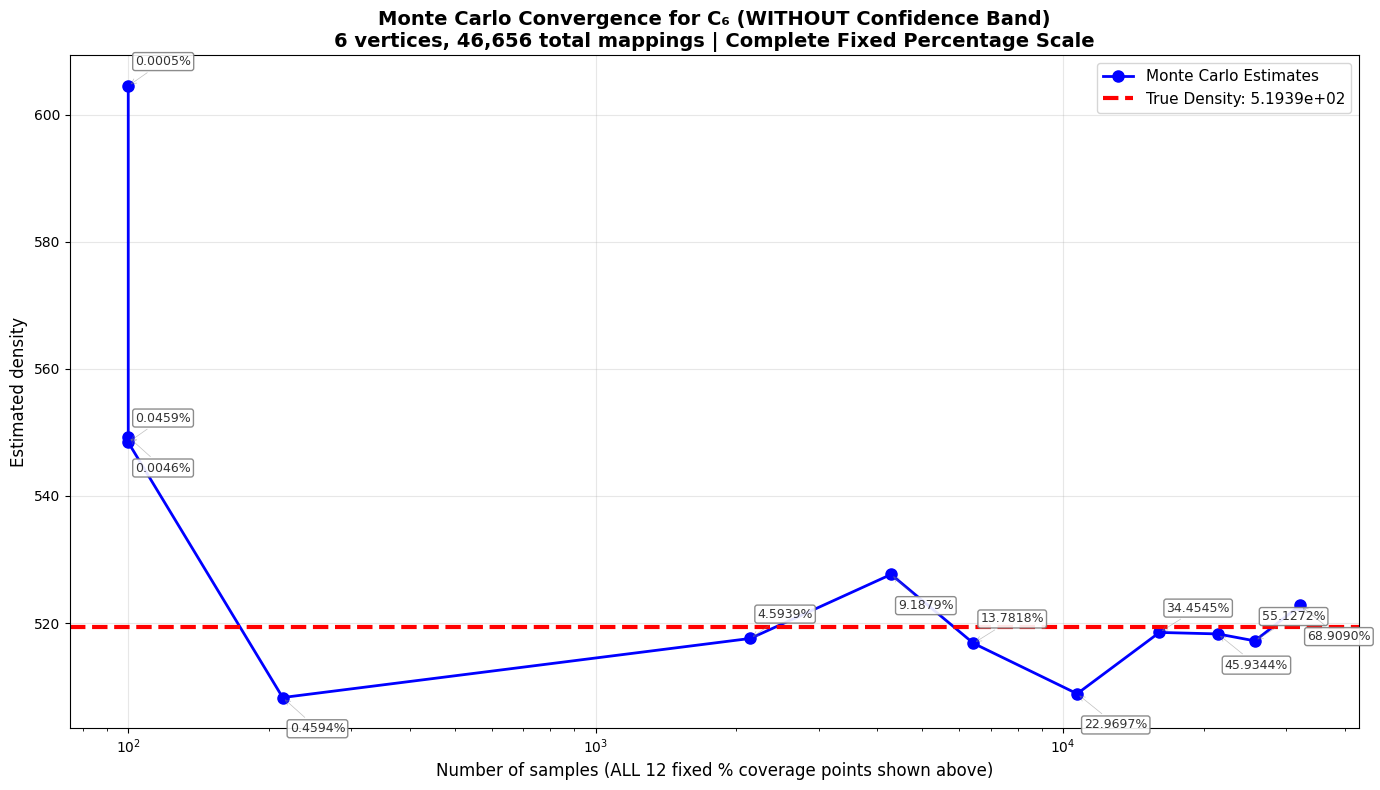


🎨 Creating convergence plot for 2×4 Grid:
📊 Creating convergence plot for 2×4 Grid
Plotting 12 out of 12 total percentage points
Fixed percentages being plotted: ['0.0005%', '0.0046%', '0.0459%', '0.4594%', '4.5939%', '9.1879%', '13.7818%', '22.9697%', '34.4545%', '45.9344%', '55.1272%', '68.9090%']


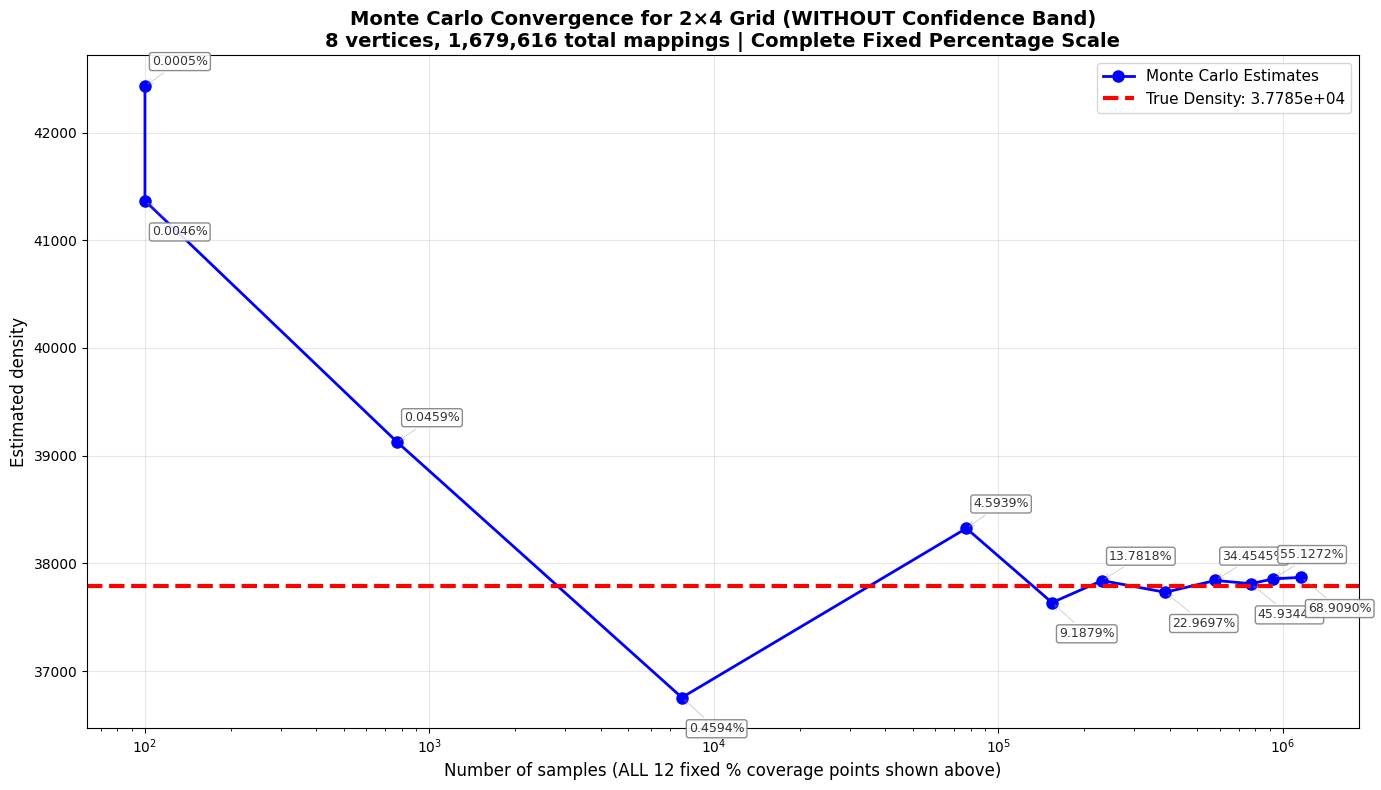


🎉 Convergence plots created successfully!
📊 Features of the plots:
  • ONLY convergence plots WITHOUT confidence bands
  • ALL 12 FIXED percentage labels on every plot
  • Exact percentages: 0.0005%, 0.0046%, 0.0459%, 0.4594%, 4.5939%,
                       9.1879%, 13.7818%, 22.9697%, 34.4545%, 45.9344%,
                       55.1272%, 68.9090%
  • Perfect consistency across both graphs
  • Clean visualization focused on convergence behavior
  • Alternating label positions to prevent overlap


In [68]:
# Cell 11: Create Convergence Plots Only

print("📈 Creating convergence plots for both larger graphs...")
print("Each plot shows ONLY the convergence WITHOUT confidence band!")
print("ALL 12 FIXED percentage points (0.0005% to 68.9090%) included!")

# Create convergence plot for C₆
print("\n" + "="*50)
print("🎨 Creating convergence plot for C₆ (6-Cycle):")
create_plots(results_c6, exact_density_c6)

# Create convergence plot for 2×4 Grid
print("\n" + "="*50)
print("🎨 Creating convergence plot for 2×4 Grid:")
create_plots(results_grid2x4, exact_density_grid2x4)

print(f"\n🎉 Convergence plots created successfully!")
print("📊 Features of the plots:")
print("  • ONLY convergence plots WITHOUT confidence bands")
print("  • ALL 12 FIXED percentage labels on every plot")
print("  • Exact percentages: 0.0005%, 0.0046%, 0.0459%, 0.4594%, 4.5939%,")
print("                       9.1879%, 13.7818%, 22.9697%, 34.4545%, 45.9344%,")
print("                       55.1272%, 68.9090%")
print("  • Perfect consistency across both graphs")
print("  • Clean visualization focused on convergence behavior")
print("  • Alternating label positions to prevent overlap")

In [69]:
# Cell 12: Generate Final Reports with Complete Percentage Coverage

print("📋 Generating comprehensive validation reports for both larger graphs...")
print("Reports include ALL 12 fixed percentage points for complete consistency!")

# Generate report for C₆
print("\n" + "="*70)
print("📄 REPORT 1: C₆ (6-CYCLE) VALIDATION - COMPLETE COVERAGE")
generate_report(results_c6, exact_density_c6, "C₆")

# Generate report for 2×4 Grid
print("\n" + "="*70)
print("📄 REPORT 2: 2×4 GRID VALIDATION - COMPLETE COVERAGE")
generate_report(results_grid2x4, exact_density_grid2x4, "2×4 Grid")


📋 Generating comprehensive validation reports for both larger graphs...
Reports include ALL 12 fixed percentage points for complete consistency!

📄 REPORT 1: C₆ (6-CYCLE) VALIDATION - COMPLETE COVERAGE

📋 MONTE CARLO VALIDATION SUMMARY REPORT

🔬 EXPERIMENTAL SETUP:
  Graph H: C₆ (6 vertices, 6 edges)
  Context: Monte Carlo convergence validation
  Target: 6×6 symmetric positive weight matrix
  Total possible mappings: 6^6 = 46,656
  True density (brute force): 5.19388615e+02
  Fixed percentage scale: 0.0005% to 68.9090%

📊 MONTE CARLO PERFORMANCE:
            100 samples (0.0005%): 6.045108e+02 (abs err: 8.51e+01, 6.6% of CI)
            100 samples (0.0046%): 5.493120e+02 (abs err: 2.99e+01, 2.6% of CI)
            100 samples (0.0459%): 5.484333e+02 (abs err: 2.90e+01, 3.0% of CI)
            214 samples (0.4594%): 5.082896e+02 (abs err: 1.11e+01, 0.9% of CI)
          2,143 samples (4.5939%): 5.175890e+02 (abs err: 1.80e+00, 0.2% of CI)
          4,286 samples (9.1879%): 5.276582e+0

In [70]:
print(W)

[[2.24724071 3.02639376 4.69330975 3.09181051 1.83626587 2.29061812]
 [3.02639376 5.19705687 2.44036237 2.99790515 2.41728137 3.42130193]
 [4.69330975 2.44036237 1.0909498  2.38577221 1.51174808 1.76942407]
 [3.09181051 2.99790515 2.38577221 0.83696316 2.41913726 3.94574214]
 [1.83626587 2.41728137 1.51174808 2.41913726 3.55448741 3.03624734]
 [2.29061812 3.42130193 1.76942407 3.94574214 3.03624734 4.85038409]]


In [71]:
print(H1_edges)

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]


In [72]:
print(H2_edges)

[(0, 1), (1, 2), (2, 3), (4, 5), (5, 6), (6, 7), (0, 4), (1, 5), (2, 6), (3, 7)]
